# Sistema de Arbitraje HFT - Pipeline Completo

## Índice

1. [Introducción](#introduccion)
2. [Configuración y Selección de Dataset](#configuracion)
3. [Fase 1: Carga de Datos](#fase1)
4. [Fase 2: Limpieza de Datos](#fase2)
5. [Fase 3: Consolidated Tape](#fase3)
6. [Fase 4: Detección de Señales](#fase4)
7. [Fase 5: Ejecución Instantánea](#fase5)
8. [Fase 6: Análisis Final](#fase6)
9. [Visualizaciones y Reportes](#visualizaciones)

---

## [WARNING] IMPORTANTE: Selección de Dataset

**Antes de ejecutar el notebook**, asegúrate de configurar el dataset en la **celda 1**:

- **DATA_SMALL**: Para pruebas rápidas (más rápido)
- **DATA_BIG**: Para análisis completo (más datos, más lento)

Cambia la variable `USE_DATA_BIG = False` a `True` si quieres usar DATA_BIG.

---

## Introducción {#introduccion}

Este notebook implementa un sistema completo de detección de arbitraje en mercados fragmentados europeos.

### La Analogía del Mercado de Frutas

Imagina que tienes **4 mercados de frutas** (XMAD, AQXE, CEUX, TRQX) donde se venden manzanas.

En cada mercado, en cada momento, hay:
- Un **VENDEDOR** con el precio **MÁS BAJO** al que está dispuesto a vender (ASK)
- Un **COMPRADOR** con el precio **MÁS ALTO** al que está dispuesto a comprar (BID)

### La Regla de Oro

**UNA OPORTUNIDAD EXISTE CUANDO:**

```
MAX(todos los bids) > MIN(todos los asks)
```

Es decir:
- El precio **MÁS ALTO** que alguien está dispuesto a **PAGAR** en CUALQUIER mercado
- Es **MAYOR** que
- El precio **MÁS BAJO** al que alguien está dispuesto a **VENDER** en CUALQUIER mercado

Cuando esto pasa → **ARBITRAJE POSIBLE** [OK]

### Ejemplo Práctico

```
Mercado XMAD:  Comprador ofrece 10.52€ | Vendedor pide 10.54€
Mercado AQXE:  Comprador ofrece 10.49€ | Vendedor pide 10.51€
Mercado CEUX:  Comprador ofrece 10.48€ | Vendedor pide 10.53€
Mercado TRQX:  Comprador ofrece 10.50€ | Vendedor pide 10.52€
```

**Análisis:**
- **Mejor comprador:** XMAD (10.52€) ← El que más paga
- **Mejor vendedor:** AQXE (10.51€) ← El que menos pide

**¡OPORTUNIDAD!** 10.52€ > 10.51€

**Tu arbitraje:**
1. Compras en AQXE por 10.51€
2. Vendes en XMAD por 10.52€
3. Ganancia: 0.01€ por manzana

Si hay 300 manzanas disponibles → Ganancia total: **3.00€**

---

## Configuración {#configuracion}

### Asunciones del Modelo

- [OK] **Latencia = 0** (ejecución instantánea)
- [OK] **Sin comisiones** de mercado
- [OK] **Profit teórico = Profit real**

### Estructura del Pipeline

```
┌─────────────────┐
│  1. CARGA       │  → Leer archivos QTE y STS
└────────┬────────┘
         │
┌────────▼────────┐
│  2. LIMPIEZA    │  → Eliminar magic numbers, filtrar por status
└────────┬────────┘
         │
┌────────▼────────┐
│  3. CONSOLIDAR  │  → Crear tape único con todos los venues
└────────┬────────┘
         │
┌────────▼────────┐
│  4. DETECTAR    │  → Buscar MAX(bid) > MIN(ask)
└────────┬────────┘
         │
┌────────▼────────┐
│  5. EJECUTAR    │  → Calcular profit (latencia=0)
└────────┬────────┘
         │
┌────────▼────────┐
│  6. ANALIZAR    │  → Generar reportes y visualizaciones
└─────────────────┘
```


In [1]:
# ============================================================================
# IMPORTS Y CONFIGURACIÓN INICIAL
# ============================================================================

import sys
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import logging
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Configurar paths
PROJECT_ROOT = Path.cwd()
sys.path.insert(0, str(PROJECT_ROOT / 'src'))

# Configurar logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)

print("[OK] Imports completados")
print(f"[INFO] Directorio de trabajo: {PROJECT_ROOT}")

# ============================================================================
# SELECTOR DE DATASET
# ============================================================================
print("\n" + "=" * 80)
print("SELECCIÓN DE DATASET")
print("=" * 80)

# Función helper para display_dataframe (igual que en main_script.py)
def display_dataframe(df: pd.DataFrame, title: str = "", max_rows: int = 20):
    """Muestra un DataFrame de forma clara y legible."""
    if df is None or len(df) == 0:
        print(f"\n  {title}: (vacío)")
        return
    
    print(f"\n  {'=' * 76}")
    if title:
        print(f"  {title}")
        print(f"  {'=' * 76}")
    
    display_df = df.head(max_rows)
    
    with pd.option_context('display.max_columns', None,
                          'display.width', None,
                          'display.max_colwidth', 50):
        print(display_df.to_string(index=False))
    
    if len(df) > max_rows:
        print(f"\n  ... (mostrando {max_rows} de {len(df)} filas totales)")
    
    print(f"  {'=' * 76}")

# Selección interactiva del dataset
print("\n[INFO] Selecciona el dataset a usar:")
print("   1. DATA_SMALL (rápido, para testing)")
print("   2. DATA_BIG (completo, para producción)")

# Por defecto usar DATA_SMALL, pero se puede cambiar manualmente
USE_DATA_BIG = False  # Cambiar a True para usar DATA_BIG

if USE_DATA_BIG:
    print("\n[OK] Seleccionado: DATA_BIG")
    DATA_DIR_NAME = "DATA_BIG"
else:
    print("\n[OK] Seleccionado: DATA_SMALL")
    DATA_DIR_NAME = "DATA_SMALL"

print(f"[INFO] Dataset seleccionado: {DATA_DIR_NAME}")
print("=" * 80)


[OK] Imports completados
[INFO] Directorio de trabajo: c:\Users\Pc\Downloads\TAREA_RENTA_VARIABLE

SELECCIÓN DE DATASET

[INFO] Selecciona el dataset a usar:
   1. DATA_SMALL (rápido, para testing)
   2. DATA_BIG (completo, para producción)

[OK] Seleccionado: DATA_SMALL
[INFO] Dataset seleccionado: DATA_SMALL


## Importar Módulos del Sistema

A continuación importamos todos los módulos necesarios:


In [2]:
# Importar todos los módulos del sistema
from config_module import config
from data_loader_module import DataLoader
from data_cleaner_module import DataCleaner
from consolidator_module import ConsolidatedTape
from signal_generator_module import SignalGenerator
from analyzer_module import ArbitrageAnalyzer

print("[OK] Todos los módulos importados correctamente")

# Configurar directorio de datos según selección
if DATA_DIR_NAME == "DATA_BIG":
    data_dir = config.DATA_BIG_DIR
else:
    data_dir = config.DATA_SMALL_DIR

print(f"\n[INFO] Configuración:")
print(f"   - Dataset seleccionado: {DATA_DIR_NAME}")
print(f"   - Directorio de datos: {data_dir}")
print(f"   - Directorio de output: {config.OUTPUT_DIR}")
print(f"   - Magic numbers a filtrar: {len(config.MAGIC_NUMBERS)} valores")
print(f"   - Venues configurados: {list(config.VALID_STATES.keys())}")

# Verificar que el directorio existe
if not data_dir.exists():
    print(f"\n[ERROR] Directorio no encontrado: {data_dir}")
    print("Por favor, asegúrate de que los datos están en la ubicación correcta")
    raise FileNotFoundError(f"Directorio no encontrado: {data_dir}")

# Limpiar outputs anteriores (igual que en main_script.py)
import shutil
print("\n[INFO] Limpiando outputs anteriores...")
if config.OUTPUT_DIR.exists():
    for item in config.OUTPUT_DIR.iterdir():
        try:
            if item.is_file():
                item.unlink()
            elif item.is_dir():
                shutil.rmtree(item)
        except Exception as e:
            print(f"  No se pudo eliminar {item}: {e}")

config.OUTPUT_DIR.mkdir(exist_ok=True)
config.FIGURES_DIR.mkdir(exist_ok=True)
print("[OK] Directorios de output listos")


[OK] Todos los módulos importados correctamente

[INFO] Configuración:
   - Dataset seleccionado: DATA_SMALL
   - Directorio de datos: c:\Users\Pc\Downloads\TAREA_RENTA_VARIABLE\data\DATA_SMALL
   - Directorio de output: c:\Users\Pc\Downloads\TAREA_RENTA_VARIABLE\output
   - Magic numbers a filtrar: 6 valores
   - Venues configurados: ['XMAD', 'AQXE', 'AQEU', 'CEUX', 'TRQX', 'TQEX']

[INFO] Limpiando outputs anteriores...
[OK] Directorios de output listos


---

## FASE 1: CARGA DE DATOS {#fase1}

### Objetivo
Cargar archivos QTE (quotes) y STS (status) desde archivos comprimidos `.csv.gz`.

### Convención de Nombres
```
<type>_<session>_<isin>_<ticker>_<mic>_<part>.csv.gz

Ejemplo:
QTE_2024-01-15_ES0113900J37_SAN_XMAD_1.csv.gz
STS_2024-01-15_ES0113900J37_SAN_XMAD_1.csv.gz
```

### Book Identity Key
Cada order book se identifica únicamente por:
```
(session, isin, mic, ticker)
```

### Columnas Requeridas

**QTE (Quotes):**
- `epoch` (int64) - Timestamp en nanosegundos UTC
- `px_bid_0`, `px_ask_0` (float64) - Precios best bid/ask
- `qty_bid_0`, `qty_ask_0` (float64) - Cantidades disponibles
- Niveles 1-9 opcionales si existen

**STS (Status):**
- `epoch` (int64) - Timestamp en nanosegundos UTC
- `market_trading_status` (int64) - Código de estado del mercado

### Diagrama de Flujo

```
┌─────────────────────────────────────┐
│  Descubrir ISINs disponibles        │
└──────────────┬──────────────────────┘
               │
┌──────────────▼──────────────────────┐
│  Para cada ISIN:                     │
│  ┌──────────────────────────────┐  │
│  │ Buscar archivos QTE y STS     │  │
│  │ para cada venue (XMAD, AQXE,  │  │
│  │ CEUX, TRQX)                    │  │
│  └──────────────┬─────────────────┘  │
│                 │                     │
│  ┌──────────────▼─────────────────┐  │
│  │ Leer CSV comprimido             │  │
│  │ - Encoding: utf-8, latin-1      │  │
│  │ - Separador: ;                  │  │
│  │ - Decimal: .                    │  │
│  └──────────────┬─────────────────┘  │
│                 │                     │
│  ┌──────────────▼─────────────────┐  │
│  │ Validar columnas requeridas     │  │
│  │ - epoch debe ser int64          │  │
│  │ - Precios y cantidades float64  │  │
│  └──────────────┬─────────────────┘  │
│                 │                     │
│  ┌──────────────▼─────────────────┐  │
│  │ Retornar Dict[mic] ->          │  │
│  │   {'qte': DataFrame,            │  │
│  │    'sts': DataFrame}            │  │
│  └────────────────────────────────┘  │
└──────────────────────────────────────┘
```


In [3]:
# ============================================================================
# FASE 1: CARGA DE DATOS
# ============================================================================

print("\n" + "=" * 80)
print("FASE 1: CARGA DE DATOS")
print("=" * 80)

# Inicializar loader con el directorio seleccionado
loader = DataLoader(data_dir)
logger = logging.getLogger(__name__)
logger.info(f"Directorio de datos: {data_dir}")

# Descubrir ISINs disponibles
print("\n[INFO] Descubriendo ISINs disponibles...")
isins = loader.discover_isins()

if len(isins) == 0:
    logger.error("No se encontraron ISINs en el directorio")
    raise ValueError("No hay datos disponibles")

# Seleccionar primer ISIN para análisis
test_isin = isins[0]
logger.info(f"Analizando ISIN: {test_isin}")
print(f"\n[INFO] ISIN seleccionado: {test_isin}")

# Cargar datos raw
print(f"\n[INFO] Cargando datos para {test_isin}...")
raw_data = loader.load_isin_data(test_isin)

if len(raw_data) == 0:
    logger.error(f"No se pudieron cargar datos para {test_isin}")
    raise ValueError("Error en carga de datos")

# Mostrar resumen detallado de carga
print(f"\n[OK] Datos cargados exitosamente:")
print(f"   Total venues: {len(raw_data)}")
for mic, venue_data in raw_data.items():
    qte_df = venue_data.get('qte', pd.DataFrame())
    sts_df = venue_data.get('sts', pd.DataFrame())
    qte_rows = len(qte_df)
    sts_rows = len(sts_df)
    print(f"\n   [INFO] {mic}:")
    print(f"      - QTE rows: {qte_rows:,}")
    print(f"      - STS rows: {sts_rows:,}")
    if qte_rows > 0:
        print(f"      - Epoch range QTE: {qte_df['epoch'].min():,} - {qte_df['epoch'].max():,}")
    if sts_rows > 0:
        print(f"      - Epoch range STS: {sts_df['epoch'].min():,} - {sts_df['epoch'].max():,}")

print(f"\n[INFO] Resumen: {len(raw_data)} venues cargados exitosamente")


2025-12-08 19:35:57,941 - data_loader_module - INFO - DataLoader initialized: c:\Users\Pc\Downloads\TAREA_RENTA_VARIABLE\data\DATA_SMALL
2025-12-08 19:35:57,942 - __main__ - INFO - Directorio de datos: c:\Users\Pc\Downloads\TAREA_RENTA_VARIABLE\data\DATA_SMALL
2025-12-08 19:35:57,945 - __main__ - INFO - Analizando ISIN: ES0113900J37



FASE 1: CARGA DE DATOS

[INFO] Descubriendo ISINs disponibles...

DESCUBRIENDO ISINs DISPONIBLES
 Encontrados 1 ISINs unicos
  Primeros 5: ['ES0113900J37']

[INFO] ISIN seleccionado: ES0113900J37

[INFO] Cargando datos para ES0113900J37...

CARGANDO DATOS PARA ISIN: ES0113900J37
  Archivos QTE encontrados: 4

  [PROCESANDO] Venue: AQEU


2025-12-08 19:36:02,726 - data_loader_module - INFO -   [OK] QTE_2025-11-07_ES0113900J37_SANe_AQEU_1.csv.gz: 101,610 filas válidas (de 101,616)
2025-12-08 19:36:02,776 - data_loader_module - INFO -   [OK] STS_2025-11-07_ES0113900J37_SANe_AQEU_1.csv.gz: 6 filas


    [OK] AQEU: 101,610 snapshots

  [PROCESANDO] Venue: XMAD


2025-12-08 19:36:13,845 - data_loader_module - WARNING -   [ADVERTENCIA] 616 filas con datos inválidos
2025-12-08 19:36:14,282 - data_loader_module - INFO -   [OK] QTE_2025-11-07_ES0113900J37_SAN_XMAD_1.csv.gz: 364,296 filas válidas (de 364,912)
2025-12-08 19:36:14,298 - data_loader_module - INFO -   [OK] STS_2025-11-07_ES0113900J37_SAN_XMAD_1.csv.gz: 7 filas


    [OK] XMAD: 364,296 snapshots

  [PROCESANDO] Venue: CEUX


2025-12-08 19:36:15,490 - data_loader_module - INFO -   [OK] QTE_2025-11-07_ES0113900J37_SANe_CEUX_1.csv.gz: 78,462 filas válidas (de 78,472)
2025-12-08 19:36:15,540 - data_loader_module - INFO -   [OK] STS_2025-11-07_ES0113900J37_SANe_CEUX_1.csv.gz: 7 filas


    [OK] CEUX: 78,462 snapshots

  [PROCESANDO] Venue: TQEX


2025-12-08 19:36:16,484 - data_loader_module - INFO -   [OK] QTE_2025-11-07_ES0113900J37_SANe_TQEX_1.csv.gz: 43,316 filas válidas (de 43,325)
2025-12-08 19:36:16,491 - data_loader_module - INFO -   [OK] STS_2025-11-07_ES0113900J37_SANe_TQEX_1.csv.gz: 3 filas


    [OK] TQEX: 43,316 snapshots

[EXITO] Venues cargados: ['AQEU', 'XMAD', 'CEUX', 'TQEX']

[OK] Datos cargados exitosamente:
   Total venues: 4

   [INFO] AQEU:
      - QTE rows: 101,610
      - STS rows: 6
      - Epoch range QTE: 1,762,502,416,697,531 - 1,762,533,000,141,495
      - Epoch range STS: 1,762,500,600,000,015 - 1,762,533,156,000,006

   [INFO] XMAD:
      - QTE rows: 364,296
      - STS rows: 7
      - Epoch range QTE: 1,762,495,202,094,554 - 1,762,534,870,304,556
      - Epoch range STS: 1,762,495,202,277,854 - 1,762,533,900,424,604

   [INFO] CEUX:
      - QTE rows: 78,462
      - STS rows: 7
      - Epoch range QTE: 1,762,502,416,697,549 - 1,762,533,375,093,153
      - Epoch range STS: 1,762,494,604,118,987 - 1,762,538,400,000,017

   [INFO] TQEX:
      - QTE rows: 43,316
      - STS rows: 3
      - Epoch range QTE: 1,762,502,416,697,156 - 1,762,533,001,057,722
      - Epoch range STS: 1,762,502,399,028,046 - 1,762,533,901,374,607

[INFO] Resumen: 4 venues cargados ex

---

## FASE 2: LIMPIEZA DE DATOS {#fase2}

### Objetivo
Eliminar datos inválidos y filtrar por estado de mercado.

### Pipeline de Limpieza (ORDEN CRÍTICO)

```
┌─────────────────────────────────────┐
│  PASO 1: Eliminar Magic Numbers     │
│  ─────────────────────────────────  │
│  Magic numbers NO son precios reales │
│  • 666666.666 → Unquoted/Unknown    │
│  • 999999.999 → Market Order        │
│  • 999999.989 → At Open Order       │
│  • 999999.988 → At Close Order      │
│  • 999999.979 → Pegged Order        │
│  • 999999.123 → Unquoted/Unknown    │
└──────────────┬──────────────────────┘
               │
┌──────────────▼──────────────────────┐
│  PASO 2: Filtrar por Trading Status │
│  ─────────────────────────────────  │
│  Solo Continuous Trading es válido:  │
│  • XMAD: [5832713, 5832756]         │
│  • AQXE: [5308427]                   │
│  • CEUX: [12255233]                  │
│  • TRQX: [7608181]                   │
│                                      │
│  Usa merge_asof con direction=       │
│  'backward' para propagar el último │
│  estado conocido a cada quote       │
└──────────────┬──────────────────────┘
               │
┌──────────────▼──────────────────────┐
│  PASO 3: Validar Precios            │
│  ─────────────────────────────────  │
│  • px_bid_0 > 0 y px_ask_0 > 0      │
│  • px_bid_0 < px_ask_0 (no crossed) │
│  • qty_bid_0 > 0 y qty_ask_0 > 0    │
│  • Precios < 10000 EUR (sanity)     │
└─────────────────────────────────────┘
```

### Validación del Book Identity Key

Antes de hacer merge QTE-STS, verificamos que pertenecen al mismo order book:

```
Book Key = (session, isin, mic, ticker)

Si QTE.session ≠ STS.session → ERROR
Si QTE.isin ≠ STS.isin → ERROR
Si QTE.ticker ≠ STS.ticker → ERROR
```

Esto previene joins incorrectos entre diferentes instrumentos.


In [ ]:
# ============================================================================
# FASE 2: LIMPIEZA DE DATOS
# ============================================================================

print("\n" + "=" * 80)
print("FASE 2: LIMPIEZA Y VALIDACIÓN")
print("=" * 80)

# Inicializar cleaner
cleaner = DataCleaner()

# Aplicar limpieza a todos los venues
print("\n[INFO] Aplicando pipeline de limpieza...")
clean_data = cleaner.clean_all_venues(raw_data)

if len(clean_data) == 0:
    print("[ERROR] No quedan datos después de la limpieza")
    raise ValueError("Todos los datos fueron eliminados en la limpieza")

# Mostrar resumen de limpieza
print(f"\n[OK] Limpieza completada:")
for mic in clean_data.keys():
    if mic in raw_data:
        original_qte = len(raw_data[mic].get('qte', pd.DataFrame()))
        cleaned_qte = len(clean_data[mic])
        retention = (cleaned_qte / original_qte * 100) if original_qte > 0 else 0
        print(f"   {mic}: {cleaned_qte:,} / {original_qte:,} rows ({retention:.2f}% retenido)")

print(f"\n[INFO] Venues válidos después de limpieza: {len(clean_data)}")


2025-12-08 19:38:51,803 - data_cleaner_module - INFO -     Códigos esperados para AQEU: [5308427]
2025-12-08 19:38:51,804 - data_cleaner_module - INFO -     Códigos encontrados en STS: [np.int64(5308426), np.int64(5308427), np.int64(5308428), np.int64(5308429)]
2025-12-08 19:38:51,804 - data_cleaner_module - INFO -     Códigos que coinciden: [5308427]
2025-12-08 19:38:51,864 - data_cleaner_module - INFO -     Snapshots con estado asignado: 101,610 (100.00%)
2025-12-08 19:38:51,866 - data_cleaner_module - INFO -     Snapshots sin estado asignado: 0 (0.00%)



FASE 2: LIMPIEZA Y VALIDACIÓN

🧹 Aplicando pipeline de limpieza...

LIMPIEZA Y VALIDACIÓN DE DATOS

  [LIMPIEZA] AQEU...
    Snapshots iniciales: 101,610


2025-12-08 19:38:52,040 - data_cleaner_module - INFO -     Distribución de estados encontrados:
2025-12-08 19:38:52,043 - data_cleaner_module - INFO -       5308427: 101,559 snapshots ([VALID])
2025-12-08 19:38:52,044 - data_cleaner_module - INFO -       5308428: 51 snapshots ([INVALID])
2025-12-08 19:38:52,082 - data_cleaner_module - INFO -     [OK] Removed 51 non-trading snapshots (0.05%)
2025-12-08 19:38:52,084 - data_cleaner_module - INFO -     [OK] Kept 101,559 continuous trading snapshots (99.95%)


    [OK] Snapshots finales: 101,559 (99.95% retenido)

  [LIMPIEZA] XMAD...
    Snapshots iniciales: 364,296


2025-12-08 19:38:52,749 - data_cleaner_module - INFO -     Removed 1 magic numbers (0.00%)
2025-12-08 19:38:52,751 - data_cleaner_module - INFO -     Códigos esperados para XMAD: [5832713, 5832756]
2025-12-08 19:38:52,751 - data_cleaner_module - INFO -     Códigos encontrados en STS: [np.int64(5832754), np.int64(5832755), np.int64(5832756), np.int64(5832757), np.int64(5832758), np.int64(5832762), np.int64(5832763)]
2025-12-08 19:38:52,752 - data_cleaner_module - INFO -     Códigos que coinciden: [5832756]
2025-12-08 19:38:52,913 - data_cleaner_module - INFO -     Snapshots con estado asignado: 364,294 (100.00%)
2025-12-08 19:38:52,914 - data_cleaner_module - INFO -     Snapshots sin estado asignado: 1 (0.00%)
2025-12-08 19:38:53,745 - data_cleaner_module - INFO -     Distribución de estados encontrados:
2025-12-08 19:38:53,746 - data_cleaner_module - INFO -       5832756: 362,895 snapshots ([VALID])
2025-12-08 19:38:53,748 - data_cleaner_module - INFO -       5832757: 979 snapshots ([I

    [OK] Snapshots finales: 362,895 (99.62% retenido)

  [LIMPIEZA] CEUX...
    Snapshots iniciales: 78,462


2025-12-08 19:38:55,527 - data_cleaner_module - INFO -     Códigos encontrados en STS: [np.int64(12255233), np.int64(12255234), np.int64(12255235), np.int64(12255237), np.int64(12255244)]
2025-12-08 19:38:55,529 - data_cleaner_module - INFO -     Códigos que coinciden: [12255233]
2025-12-08 19:38:55,588 - data_cleaner_module - INFO -     Snapshots con estado asignado: 78,462 (100.00%)
2025-12-08 19:38:55,593 - data_cleaner_module - INFO -     Snapshots sin estado asignado: 0 (0.00%)
2025-12-08 19:38:55,729 - data_cleaner_module - INFO -     Distribución de estados encontrados:
2025-12-08 19:38:55,730 - data_cleaner_module - INFO -       12255233: 78,375 snapshots ([VALID])
2025-12-08 19:38:55,731 - data_cleaner_module - INFO -       12255237: 50 snapshots ([INVALID])
2025-12-08 19:38:55,732 - data_cleaner_module - INFO -       12255244: 37 snapshots ([INVALID])
2025-12-08 19:38:55,769 - data_cleaner_module - INFO -     [OK] Removed 87 non-trading snapshots (0.11%)
2025-12-08 19:38:55,7

    [OK] Snapshots finales: 78,375 (99.89% retenido)

  [LIMPIEZA] TQEX...
    Snapshots iniciales: 43,316


2025-12-08 19:38:56,248 - data_cleaner_module - INFO -     Distribución de estados encontrados:
2025-12-08 19:38:56,250 - data_cleaner_module - INFO -       7608181: 43,316 snapshots ([VALID])
2025-12-08 19:38:56,395 - data_cleaner_module - INFO - Quality metrics: 587,684 → 586,145 (99.74% retained)


    [OK] Snapshots finales: 43,316 (100.00% retenido)

  [MÉTRICAS DE CALIDAD AGREGADAS]
    Filas originales: 587,684
    Eliminadas por magic numbers: 1 (0.00%)
    Eliminadas por status inválido: 1,538 (0.26%)
    Eliminadas por validaciones: 0 (0.00%)
    Filas finales: 586,145 (99.74% retenido)

[EXITO] Limpieza completada para 4 venues

✅ Limpieza completada:
   AQEU: 101,559 / 101,610 rows (99.95% retenido)
   XMAD: 362,895 / 364,296 rows (99.62% retenido)
   CEUX: 78,375 / 78,462 rows (99.89% retenido)
   TQEX: 43,316 / 43,316 rows (100.00% retenido)

📊 Venues válidos después de limpieza: 4


---

## FASE 3: CONSOLIDATED TAPE {#fase3}

### Objetivo
Crear un DataFrame único donde cada fila es un instante de tiempo y las columnas contienen los precios de TODOS los venues simultáneamente.

### Estructura del Consolidated Tape

```
| epoch | XMAD_bid | XMAD_ask | XMAD_bid_qty | XMAD_ask_qty |
|       | AQXE_bid | AQXE_ask | AQXE_bid_qty | AQXE_ask_qty |
|       | CEUX_bid | CEUX_ask | CEUX_bid_qty | CEUX_ask_qty |
|       | TRQX_bid | TRQX_ask | TRQX_bid_qty | TRQX_ask_qty |
```

### Algoritmo

```
┌─────────────────────────────────────┐
│  PASO 1: Renombrar columnas         │
│  px_bid_0 → {MIC}_bid               │
│  px_ask_0 → {MIC}_ask               │
│  qty_bid_0 → {MIC}_bid_qty          │
│  qty_ask_0 → {MIC}_ask_qty          │
└──────────────┬──────────────────────┘
               │
┌──────────────▼──────────────────────┐
│  PASO 2: Merge iterativo             │
│  ─────────────────────────────────  │
│  • Empezar con primer venue          │
│  • Outer merge con cada venue        │
│  • Usar 'epoch' como key             │
│  • Resultado: todos los timestamps   │
│    únicos de todos los venues        │
└──────────────┬──────────────────────┘
               │
┌──────────────▼──────────────────────┐
│  PASO 3: Ordenar por timestamp      │
│  sort_values('epoch')               │
└──────────────┬──────────────────────┘
               │
┌──────────────▼──────────────────────┐
│  PASO 4: Forward Fill (CRÍTICO)      │
│  ─────────────────────────────────  │
│  Asunción de market microstructure: │
│  El último precio conocido sigue    │
│  vigente hasta que llegue un update  │
│                                      │
│  Ejemplo:                            │
│  XMAD actualiza en T=100 y T=200    │
│  → Precio en T=150 = precio de T=100│
└──────────────┬──────────────────────┘
               │
┌──────────────▼──────────────────────┐
│  PASO 5: Eliminar filas iniciales    │
│  con NaNs (si todas las columnas    │
│  son NaN)                            │
└─────────────────────────────────────┘
```

### ¿Por qué Forward Fill?

En mercados fragmentados, cada venue actualiza a diferentes frecuencias:
- XMAD puede actualizar cada 100ms
- AQXE puede actualizar cada 200ms
- CEUX puede actualizar cada 150ms

Sin forward fill, tendríamos NaNs en cada timestamp donde un venue no actualiza, lo cual haría **imposible comparar precios** entre venues.

Con forward fill, asumimos que el último precio conocido sigue vigente hasta el próximo update, que es estándar en análisis de order books.


In [ ]:
# ============================================================================
# FASE 3: CONSOLIDATED TAPE
# ============================================================================

print("\n" + "=" * 80)
print("FASE 3: CONSOLIDATED TAPE")
print("=" * 80)

# Crear consolidador (con redondeo temporal opcional para datasets grandes)
tape_builder = ConsolidatedTape(time_bin_ms=100)  # 100ms bins

print("\n[INFO] Consolidando datos de todos los venues...")
consolidated_tape = tape_builder.create_tape(clean_data)

if consolidated_tape is None or len(consolidated_tape) == 0:
    print("[ERROR] Consolidated tape vacío o nulo")
    raise ValueError("Error creando consolidated tape")

# Validar tape
print("\n[OK] Validando consolidated tape...")
is_valid = tape_builder.validate_tape(consolidated_tape)

if not is_valid:
    print("[ERROR] Consolidated tape falló la validación")
    raise ValueError("Tape inválido")

# Mostrar estadísticas
print(f"\n[INFO] Estadísticas del Consolidated Tape:")
print(f"   - Total timestamps únicos: {len(consolidated_tape):,}")
print(f"   - Columnas totales: {len(consolidated_tape.columns)}")
print(f"   - Venues incluidos: {len(clean_data)}")

# Mostrar preview
print(f"\n[INFO] Preview del Consolidated Tape (primeras 5 filas):")
display_cols = ['epoch'] + [col for col in consolidated_tape.columns if '_bid' in col or '_ask' in col][:8]
print(consolidated_tape[display_cols].head())


2025-12-08 19:42:27,611 - consolidator_module - INFO - ConsolidatedTape initialized: time_bin=100ms



FASE 3: CONSOLIDATED TAPE

🔗 Consolidando datos de todos los venues...

CREANDO CONSOLIDATED TAPE
  Venues a consolidar: ['AQEU', 'XMAD', 'CEUX', 'TQEX']
   AQEU: 306 snapshots preparados
   XMAD: 307 snapshots preparados
   CEUX: 306 snapshots preparados
   TQEX: 307 snapshots preparados

  Usando XMAD como base (307 rows)
    Merging con TQEX... OK (307 rows)
    Merging con AQEU... OK (307 rows)
    Merging con CEUX... OK (307 rows)

  [OK] Tape consolidado creado: (307, 17)
    - Timestamps únicos: 307
    - Columnas totales: 17

  Aplicando forward fill...
    NaNs antes: 0
    NaNs después: 0

  Tape final: (307, 17)

  [ESTADISTICAS DE COBERTURA]
    AQEU: 307 rows válidas (100.0% cobertura)
    XMAD: 307 rows válidas (100.0% cobertura)
    CEUX: 307 rows válidas (100.0% cobertura)
    TQEX: 307 rows válidas (100.0% cobertura)

✅ Validando consolidated tape...

VALIDANDO CONSOLIDATED TAPE
  [OK] No NaNs después de las primeras 100 filas
  [OK] Timestamps monotónicamente crecien

---

## FASE 4: DETECCIÓN DE SEÑALES {#fase4}

### Objetivo
Detectar oportunidades donde `MAX(bid) > MIN(ask)`.

### Algoritmo Paso a Paso

```
┌─────────────────────────────────────┐
│  PASO 1: Identificar columnas       │
│  • bid_cols = [XMAD_bid, AQXE_bid,  │
│                CEUX_bid, TRQX_bid]  │
│  • ask_cols = [XMAD_ask, AQXE_ask,  │
│                CEUX_ask, TRQX_ask]  │
└──────────────┬──────────────────────┘
               │
┌──────────────▼──────────────────────┐
│  PASO 2: Calcular Global Max Bid   │
│  ─────────────────────────────────  │
│  En cada momento:                    │
│  max_bid = MAX(todos los bids)      │
│  venue_max_bid = venue con max_bid  │
│                                      │
│  Ejemplo:                            │
│  XMAD: 10.52€                        │
│  AQXE: 10.49€                        │
│  CEUX: 10.48€                        │
│  TRQX: 10.50€                        │
│  → max_bid = 10.52€ (XMAD)          │
└──────────────┬──────────────────────┘
               │
┌──────────────▼──────────────────────┐
│  PASO 3: Calcular Global Min Ask    │
│  ─────────────────────────────────  │
│  En cada momento:                    │
│  min_ask = MIN(todos los asks)      │
│  venue_min_ask = venue con min_ask  │
│                                      │
│  Ejemplo:                            │
│  XMAD: 10.54€                        │
│  AQXE: 10.51€                        │
│  CEUX: 10.53€                        │
│  TRQX: 10.52€                        │
│  → min_ask = 10.51€ (AQXE)          │
└──────────────┬──────────────────────┘
               │
┌──────────────▼──────────────────────┐
│  PASO 4: Aplicar Regla de Oro       │
│  ─────────────────────────────────  │
│  signal = 1 si max_bid > min_ask    │
│  signal = 0 si no                   │
│                                      │
│  Ejemplo:                            │
│  max_bid = 10.52€ (XMAD)            │
│  min_ask = 10.51€ (AQXE)            │
│  10.52€ > 10.51€ → [OK] Oportunidad!  │
└──────────────┬──────────────────────┘
               │
┌──────────────▼──────────────────────┐
│  PASO 5: Calcular Cantidades        │
│  ─────────────────────────────────  │
│  • Extraer qty del venue_max_bid    │
│  • Extraer qty del venue_min_ask    │
│  • executable_qty = min(bid_qty,    │
│                        ask_qty)     │
└──────────────┬──────────────────────┘
               │
┌──────────────▼──────────────────────┐
│  PASO 6: Calcular Profit            │
│  ─────────────────────────────────  │
│  theoretical_profit = max_bid -     │
│                       min_ask        │
│  total_profit = theoretical_profit  │
│                  × executable_qty    │
└──────────────┬──────────────────────┘
               │
┌──────────────▼──────────────────────┐
│  PASO 7: Rising Edge Detection      │
│  ─────────────────────────────────  │
│  Solo contar la PRIMERA aparición   │
│  de cada oportunidad continua       │
│                                      │
│  Si una oportunidad persiste 1000   │
│  snapshots, solo la contamos UNA vez│
└─────────────────────────────────────┘
```

### Rising Edge Detection

**Problema:** Si una oportunidad persiste durante muchos snapshots, no queremos contarla múltiples veces.

**Solución:** Rising Edge Detection identifica solo la **primera aparición** de cada oportunidad continua.

```
Snapshot 1: signal = 0 → No oportunidad
Snapshot 2: signal = 1 → RISING EDGE (nueva oportunidad)
Snapshot 3: signal = 1 → No (continuación de oportunidad anterior)
Snapshot 4: signal = 1 → No (continuación)
Snapshot 5: signal = 0 → Oportunidad desapareció
Snapshot 6: signal = 1 → RISING EDGE (nueva oportunidad)
```

**Algoritmo:**
```python
prev_signal = signal.shift(1, fill_value=0)
is_rising_edge = (signal == 1) & (prev_signal == 0)
```


In [ ]:
# ============================================================================
# FASE 4: DETECCIÓN DE SEÑALES DE ARBITRAJE
# ============================================================================

print("\n" + "=" * 80)
print("FASE 4: DETECCIÓN DE SEÑALES DE ARBITRAJE")
print("=" * 80)

# Inicializar generador de señales
signal_gen = SignalGenerator()

# Inicializar lista de trades ejecutados (vacía al inicio)
executed_trades = []

# Detectar oportunidades
print("\n[INFO] Detectando oportunidades de arbitraje...")
signals_df = signal_gen.detect_opportunities(
    consolidated_tape,
    executed_trades=executed_trades,
    isin=test_isin
)

if signals_df is None or len(signals_df) == 0:
    print("[ERROR] No se detectaron señales")
    signals_df = pd.DataFrame()
else:
    # Mostrar resumen
    rising_edges = signals_df[signals_df['is_rising_edge']]
    total_opps = len(rising_edges)
    
    print(f"\n[OK] Señales detectadas:")
    print(f"   - Total snapshots analizados: {len(signals_df):,}")
    print(f"   - Snapshots con arbitraje: {signals_df['signal'].sum():,}")
    print(f"   - Rising edges (oportunidades únicas): {total_opps:,}")
    
    if total_opps > 0:
        total_profit = rising_edges['total_profit'].sum()
        avg_profit = rising_edges['total_profit'].mean()
        print(f"   - Profit teórico total: €{total_profit:,.2f}")
        print(f"   - Profit medio por oportunidad: €{avg_profit:.2f}")
        
        # Mostrar primeras oportunidades
        print(f"\n[INFO] Primeras 5 oportunidades detectadas:")
        opp_cols = ['epoch', 'venue_max_bid', 'venue_min_ask', 
                   'executable_qty', 'theoretical_profit', 'total_profit']
        available_cols = [c for c in opp_cols if c in rising_edges.columns]
        print(rising_edges[available_cols].head().to_string(index=False))
    
    # Analizar pares de venues
    print("\n[INFO] Analizando pares de venues...")
    venue_pairs = signal_gen.analyze_venue_pairs(signals_df)
    if venue_pairs is not None and len(venue_pairs) > 0:
        print("\n[INFO] Top pares de venues por profit:")
        print(venue_pairs.head().to_string(index=False))


2025-12-08 19:44:28,598 - signal_generator_module - INFO - Validación: 2 señales válidas, profit total: €13.29



FASE 4: DETECCIÓN DE SEÑALES DE ARBITRAJE

🔍 Detectando oportunidades de arbitraje...

DETECCIÓN DE SEÑALES DE ARBITRAJE
  Mercados detectados: ['AQEU', 'CEUX', 'TQEX', 'XMAD']
  Total momentos analizados: 307

  PASO 2: Buscando el mejor comprador en cada momento...
  PASO 3: Buscando el mejor vendedor en cada momento...
  PASO 4: Aplicando la regla de oro...
    ¿MAX(bid) > MIN(ask)?

  ✓ Oportunidades detectadas: 2 de 307 momentos
    (0.6515% de los momentos tienen arbitraje)

  PASO 5: Calculando cantidades y ganancias...
  Aplicando Rising Edge Detection...
  Validando señales...

  RESULTADOS:
    - Total snapshots: 307
    - Snapshots con arbitraje: 2 (0.65%)
    - Rising edges detectados: 2
    - Rising edges válidos: 2
    - Profit teórico total: €13.29
    - Profit medio: €6.64
    - Profit máximo: €13.29

✅ Señales detectadas:
   - Total snapshots analizados: 307
   - Snapshots con arbitraje: 2
   - Rising edges (oportunidades únicas): 2
   - Profit teórico total: €13.29
 

---

## FASE 5: EJECUCIÓN INSTANTÁNEA {#fase5}

### Objetivo
Calcular el profit real asumiendo ejecución instantánea (latencia = 0, sin comisiones).

### Asunciones del Modelo

```
┌─────────────────────────────────────┐
│  Latencia = 0                        │
│  ─────────────────────────────────  │
│  • Detección y ejecución simultáneas │
│  • No hay delay entre detectar y     │
│    ejecutar                          │
│  • execution_epoch = signal_epoch    │
└─────────────────────────────────────┘

┌─────────────────────────────────────┐
│  Sin Comisiones                      │
│  ─────────────────────────────────  │
│  • No hay costos de trading          │
│  • No hay fees de exchange           │
│  • Profit teórico = Profit real      │
└─────────────────────────────────────┘
```

### Cálculo de Profit Real

```
real_profit = theoretical_profit
real_total_profit = total_profit
profit_category = 'Profitable' (todas)
```

**Nota:** En un modelo más realista, habría que:
1. Simular latencia (time machine)
2. Recalcular precios en el momento de ejecución
3. Aplicar comisiones
4. Verificar que la oportunidad sigue existiendo

Pero en este modelo simplificado, asumimos ejecución perfecta e instantánea.


In [ ]:
# ============================================================================
# FASE 5: EJECUCIÓN INSTANTÁNEA (LATENCIA = 0, SIN COMISIONES)
# ============================================================================

print("\n" + "=" * 80)
print("FASE 5: EJECUCIÓN INSTANTÁNEA")
print("=" * 80)

print("\n[INFO] Asunciones del modelo:")
print("   • Latencia = 0 (ejecución instantánea)")
print("   • Sin comisiones de mercado")
print("   • Profit teórico = Profit real")

exec_df = None

if signals_df is not None and len(signals_df) > 0:
    # Filtrar solo rising edges (oportunidades únicas)
    rising_edges = signals_df[signals_df['is_rising_edge']]
    
    if len(rising_edges) > 0:
        # Crear DataFrame de ejecuciones
        exec_df = rising_edges.copy()
        exec_df['execution_epoch'] = exec_df['epoch']  # Ejecución instantánea
        exec_df['executed_qty'] = exec_df['executable_qty']
        exec_df['real_profit'] = exec_df['theoretical_profit']  # Sin pérdida por latencia
        exec_df['real_total_profit'] = exec_df['total_profit']  # Profit total real
        exec_df['profit_category'] = 'Profitable'  # Todas son profitable
        
        print(f"\n[OK] Ejecuciones simuladas:")
        print(f"   - Total oportunidades ejecutables: {len(exec_df):,}")
        print(f"   - Profit total real: €{exec_df['real_total_profit'].sum():,.2f}")
        
        # Mostrar primeras ejecuciones
        print(f"\n[INFO] Primeras 5 ejecuciones:")
        exec_cols = ['epoch', 'execution_epoch', 'venue_max_bid', 'venue_min_ask',
                    'executed_qty', 'real_profit', 'real_total_profit']
        available_cols = [c for c in exec_cols if c in exec_df.columns]
        print(exec_df[available_cols].head().to_string(index=False))
    else:
        print("[WARNING] No hay rising edges para ejecutar")
else:
    print("[WARNING] No hay señales para ejecutar")



FASE 5: EJECUCIÓN INSTANTÁNEA

📌 Asunciones del modelo:
   • Latencia = 0 (ejecución instantánea)
   • Sin comisiones de mercado
   • Profit teórico = Profit real

✅ Ejecuciones simuladas:
   - Total oportunidades ejecutables: 2
   - Profit total real: €13.29

📋 Primeras 5 ejecuciones:
           epoch  execution_epoch venue_max_bid venue_min_ask  executed_qty  real_profit  real_total_profit
1762523900000000 1762523900000000          CEUX          XMAD         518.0 2.288818e-07           0.000119
1762533000000000 1762533000000000          AQEU          XMAD         949.0 1.400047e-02          13.286449


---

## FASE 6: ANÁLISIS FINAL {#fase6}

### Objetivo
Generar métricas agregadas y estadísticas descriptivas.

### Métricas Calculadas

```
┌─────────────────────────────────────┐
│  Métricas por Oportunidad           │
│  ─────────────────────────────────  │
│  • Total oportunidades detectadas   │
│  • Total profit teórico              │
│  • Profit medio por oportunidad     │
│  • Profit máximo                     │
│  • Cantidad media ejecutable         │
└─────────────────────────────────────┘

┌─────────────────────────────────────┐
│  Métricas de ROI                    │
│  ─────────────────────────────────  │
│  • Capital requerido                │
│  • Profit total                     │
│  • ROI porcentual                   │
│  • Profit por unidad de capital     │
└─────────────────────────────────────┘
```

### Análisis de Pares de Venues

Identifica qué combinaciones de venues generan más oportunidades:

```
Ejemplo:
Buy@AQXE / Sell@XMAD: 150 oportunidades, €450.00 total profit
Buy@CEUX / Sell@XMAD: 89 oportunidades, €234.50 total profit
...
```


In [ ]:
# ============================================================================
# FASE 6: ANÁLISIS FINAL
# ============================================================================

print("\n" + "=" * 80)
print("FASE 6: ANÁLISIS FINAL")
print("=" * 80)

metrics = None
roi_metrics = None

if signals_df is not None and exec_df is not None and len(exec_df) > 0:
    analyzer = ArbitrageAnalyzer()
    
    print("\n[INFO] Analizando oportunidades...")
    metrics = analyzer.analyze_opportunities(signals_df, exec_df)
    
    print("\n[INFO] Estimando ROI...")
    # Sin comisiones: trading_costs_bps = 0
    roi_metrics = analyzer.estimate_roi(metrics, trading_costs_bps=0.0, capital_eur=100000)
    
    # Mostrar métricas
    if metrics:
        print("\n[OK] Métricas del análisis:")
        metrics_df = pd.DataFrame([metrics])
        print(metrics_df.to_string(index=False))
    
    if roi_metrics:
        print("\n[OK] Métricas de ROI:")
        roi_df = pd.DataFrame([roi_metrics])
        print(roi_df.to_string(index=False))
    
    # Generar reporte
    print("\n[INFO] Generando reporte final...")
    analyzer.generate_summary_report(
        metrics,
        roi_metrics,
        output_path=config.OUTPUT_DIR / f'report_{test_isin}.txt'
    )
    print("[OK] Reporte generado")
else:
    print("[WARNING] No hay datos suficientes para análisis final")


2025-12-08 19:45:24,483 - analyzer_module - INFO - ArbitrageAnalyzer initialized



FASE 6: ANÁLISIS FINAL

📊 Analizando oportunidades...

ANÁLISIS DE OPORTUNIDADES DE ARBITRAJE
  Total snapshots: 307
  Rising edges: 2
  Oportunidades válidas: 2
  Profit teórico total: €13.29
  Profit real: €13.29
  Oportunidades profitable: 2

💰 Estimando ROI...

ESTIMACIÓN DE ROI
  ROI: 0.0133%
  ROI anualizado: 9271.98%

✅ Métricas del análisis:
                                                                                                                                                                                     detection                                                                  theoretical_profit                                                                     real_profit                                                                                             temporal                                                                                                                                                                venue_pairs
{'total_snapshots': 

---

## VISUALIZACIONES Y REPORTES {#visualizaciones}

### Gráficas Generadas

1. **Consolidated Tape**: Muestra la evolución de precios bid/ask de todos los venues
2. **Señales Detectadas**: Visualiza las oportunidades de arbitraje en el tiempo
3. **Análisis de Pares**: Gráfico de barras con profit por par de venues

### Archivos Generados

- `opportunities_{ISIN}.csv`: Todas las oportunidades detectadas
- `execution_{ISIN}.csv`: Todas las ejecuciones simuladas
- `report_{ISIN}.txt`: Reporte de métricas y ROI
- `complete_report_{ISIN}.md`: Documento Markdown completo
- `figures/`: Directorio con todas las gráficas



VISUALIZACIONES Y EXPORTACIÓN

📊 Generando visualizaciones...

Generando visualizaciones de señales...
  Visualización guardada en: c:\Users\Pc\Downloads\TAREA_RENTA_VARIABLE\output\figures\signals_ES0113900J37.png


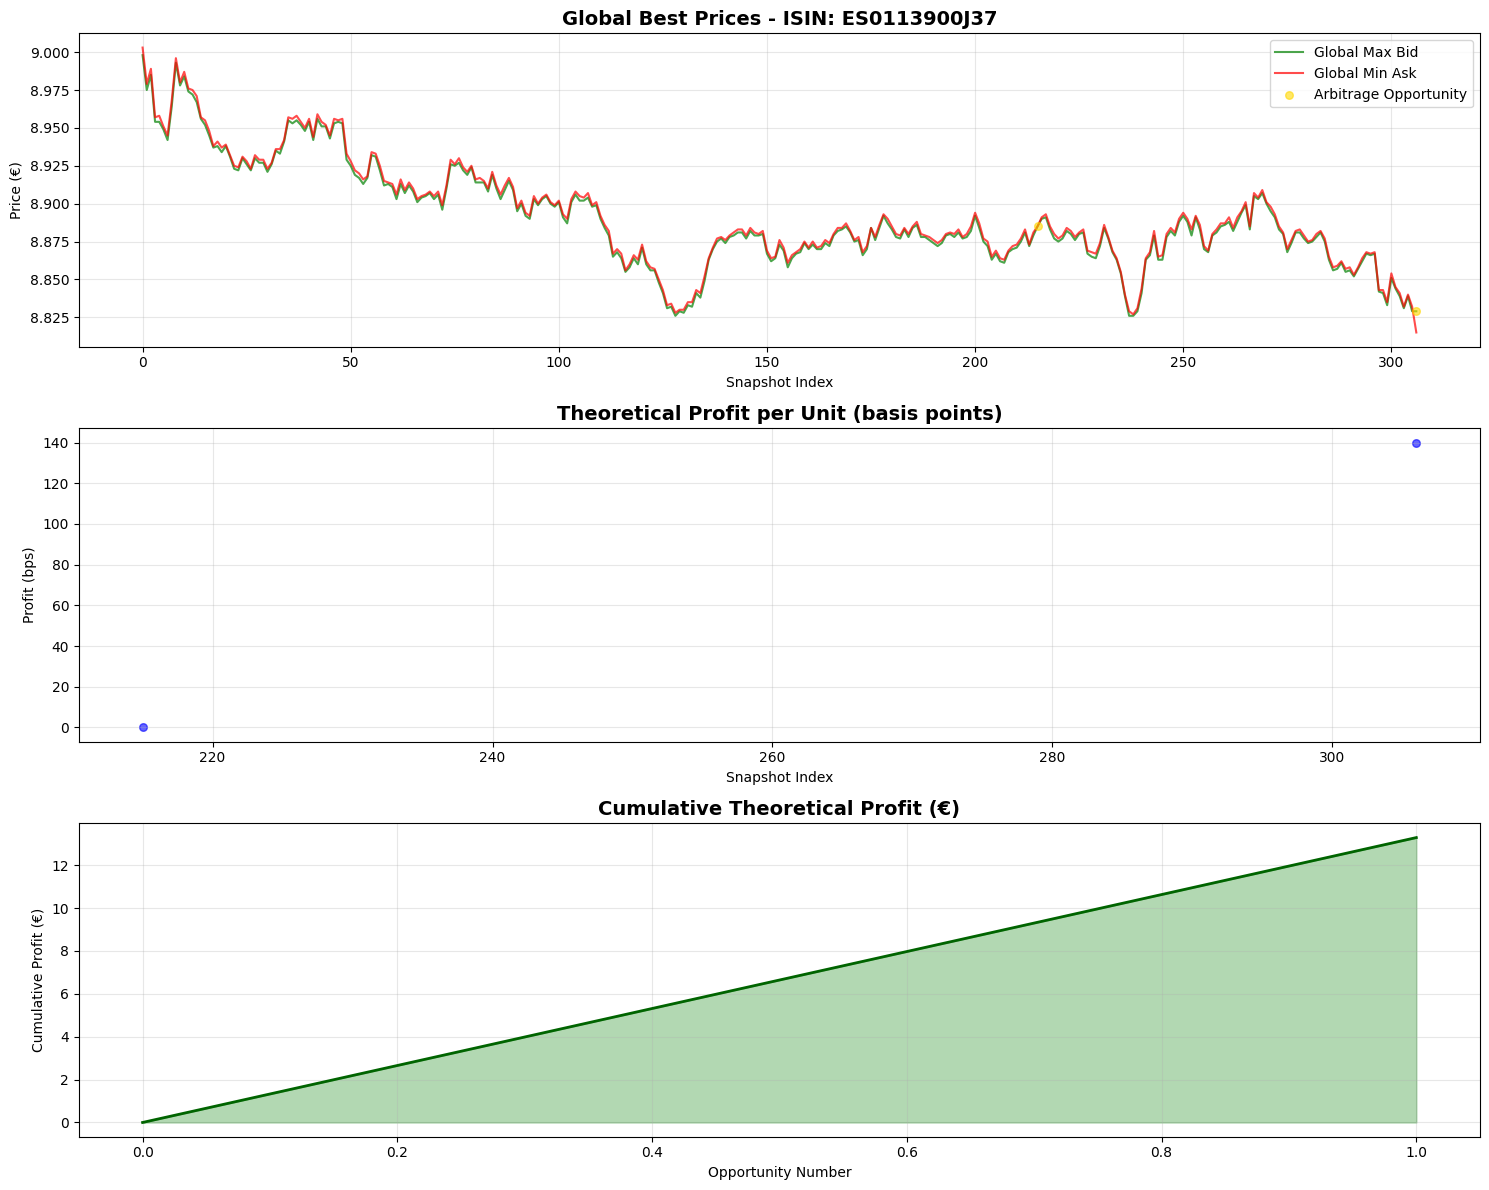


Generando visualizaciones...
  Visualización guardada en: c:\Users\Pc\Downloads\TAREA_RENTA_VARIABLE\output\figures\consolidated_tape_ES0113900J37.png


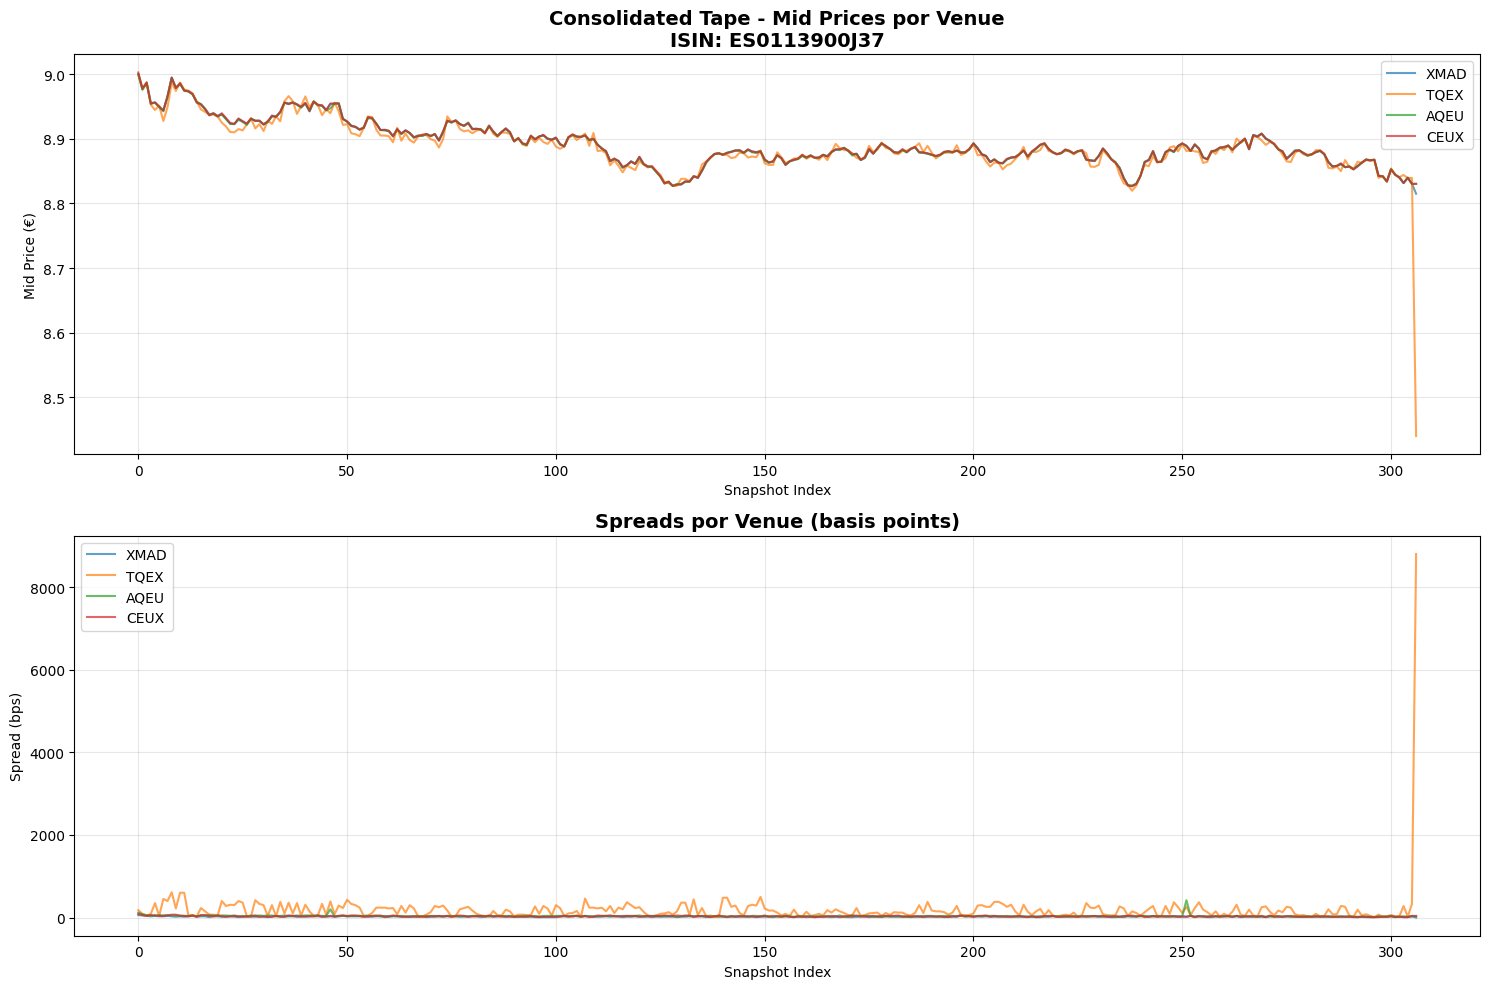


💾 Exportando oportunidades...

  Oportunidades exportadas a: c:\Users\Pc\Downloads\TAREA_RENTA_VARIABLE\output\opportunities_ES0113900J37.csv
    Total oportunidades: 2
✅ Ejecuciones exportadas

✅ Visualizaciones generadas
   📁 Archivos guardados en: c:\Users\Pc\Downloads\TAREA_RENTA_VARIABLE\output
   🖼️  Gráficas guardadas en: c:\Users\Pc\Downloads\TAREA_RENTA_VARIABLE\output\figures


In [ ]:
# ============================================================================
# VISUALIZACIONES Y EXPORTACIÓN
# ============================================================================

print("\n" + "=" * 80)
print("VISUALIZACIONES Y EXPORTACIÓN")
print("=" * 80)

if signals_df is not None and len(signals_df) > 0:
    # Visualizar señales
    print("\n[INFO] Generando visualizaciones...")
    signal_gen.visualize_signals(signals_df, test_isin)
    
    # Visualizar consolidated tape
    tape_builder.visualize_tape(consolidated_tape, test_isin)
    
    # Exportar oportunidades
    print("\n[INFO] Exportando oportunidades...")
    signal_gen.export_opportunities(
        signals_df,
        output_path=config.OUTPUT_DIR / f"opportunities_{test_isin}.csv"
    )
    
    # Exportar ejecuciones
    if exec_df is not None and len(exec_df) > 0:
        exec_cols = ['epoch', 'execution_epoch', 'venue_max_bid', 'venue_min_ask',
                    'executed_qty', 'real_profit', 'real_total_profit', 'profit_category']
        exec_df[[c for c in exec_cols if c in exec_df.columns]].to_csv(
            config.OUTPUT_DIR / f"execution_{test_isin}.csv",
            index=False
        )
        print("[OK] Ejecuciones exportadas")
    
    print("\n[OK] Visualizaciones generadas")
    print(f"   [INFO] Archivos guardados en: {config.OUTPUT_DIR}")
    print(f"   [INFO] Gráficas guardadas en: {config.FIGURES_DIR}")
else:
    print("[WARNING] No hay señales para visualizar")


---

## RESUMEN FINAL

### Resultados del Análisis

A continuación se muestra un resumen completo de todos los resultados obtenidos.


In [10]:
# ============================================================================
# RESUMEN FINAL
# ============================================================================

print("\n" + "=" * 80)
print("RESUMEN DEL ANÁLISIS")
print("=" * 80)

print(f"\n[INFO] ISIN: {test_isin}")
print(f"   - Dataset usado: {DATA_DIR_NAME}")
print(f"   - Total snapshots en tape: {len(consolidated_tape):,}")
print(f"   - Venues incluidos: {len(clean_data)}")

if signals_df is not None and len(signals_df) > 0:
    total_opportunities = signals_df['is_rising_edge'].sum()
    total_profit = signals_df[signals_df['is_rising_edge']]['total_profit'].sum()
    
    print(f"\n[INFO] Oportunidades:")
    print(f"   - Detectadas: {total_opportunities:,}")
    print(f"   - Profit total (ejecución instantánea): €{total_profit:,.2f}")
    
    if total_opportunities > 0:
        avg_profit = signals_df[signals_df['is_rising_edge']]['total_profit'].mean()
        print(f"   - Profit medio por oportunidad: €{avg_profit:.2f}")

if exec_df is not None and len(exec_df) > 0:
    profitable_ops = len(exec_df)
    real_profit = exec_df['real_total_profit'].sum()
    print(f"\n[INFO] Ejecuciones:")
    print(f"   - Oportunidades ejecutadas: {profitable_ops:,}")
    print(f"   - Profit real total: €{real_profit:,.2f}")

if roi_metrics:
    print(f"\n[INFO] ROI:")
    print(f"   - ROI estimado: {roi_metrics.get('roi_pct', 0):.4f}%")

print("\n" + "=" * 80)
print("[ÉXITO] ANÁLISIS COMPLETADO CON ÉXITO")
print("=" * 80)

# Mostrar archivos generados
print(f"\n[INFO] Archivos generados:")
print(f"   - Log: {config.OUTPUT_DIR / 'arbitrage_system.log'}")
if signals_df is not None and len(signals_df) > 0:
    print(f"   - Oportunidades: {config.OUTPUT_DIR / f'opportunities_{test_isin}.csv'}")
if exec_df is not None and len(exec_df) > 0:
    print(f"   - Ejecuciones: {config.OUTPUT_DIR / f'execution_{test_isin}.csv'}")
if metrics:
    print(f"   - Reporte: {config.OUTPUT_DIR / f'report_{test_isin}.txt'}")
print(f"   - Figuras: {config.FIGURES_DIR}")



RESUMEN DEL ANÁLISIS

[INFO] ISIN: ES0113900J37
   - Dataset usado: DATA_SMALL
   - Total snapshots en tape: 307
   - Venues incluidos: 4

[INFO] Oportunidades:
   - Detectadas: 2
   - Profit total (ejecución instantánea): €13.29
   - Profit medio por oportunidad: €6.64

[INFO] Ejecuciones:
   - Oportunidades ejecutadas: 2
   - Profit real total: €13.29

[INFO] ROI:
   - ROI estimado: 0.0133%

[ÉXITO] ANÁLISIS COMPLETADO CON ÉXITO

[INFO] Archivos generados:
   - Log: c:\Users\Pc\Downloads\TAREA_RENTA_VARIABLE\output\arbitrage_system.log
   - Oportunidades: c:\Users\Pc\Downloads\TAREA_RENTA_VARIABLE\output\opportunities_ES0113900J37.csv
   - Ejecuciones: c:\Users\Pc\Downloads\TAREA_RENTA_VARIABLE\output\execution_ES0113900J37.csv
   - Reporte: c:\Users\Pc\Downloads\TAREA_RENTA_VARIABLE\output\report_ES0113900J37.txt
   - Figuras: c:\Users\Pc\Downloads\TAREA_RENTA_VARIABLE\output\figures


---

## EXPLORACIÓN ADICIONAL

### Visualizar Datos Intermedios

Puedes explorar los datos en cualquier punto del pipeline usando las variables:

- `raw_data`: Datos después de la carga
- `clean_data`: Datos después de la limpieza
- `consolidated_tape`: Tape consolidado con todos los venues
- `signals_df`: DataFrame con todas las señales detectadas
- `exec_df`: DataFrame con todas las ejecuciones simuladas

### Ejemplos de Exploración

```python
# Ver distribución de precios en el consolidated tape
consolidated_tape[['XMAD_bid', 'XMAD_ask', 'AQXE_bid', 'AQXE_ask']].describe()

# Ver oportunidades por venue pair
signals_df[signals_df['is_rising_edge']].groupby(['venue_max_bid', 'venue_min_ask']).size()

# Ver evolución temporal del profit
signals_df[signals_df['is_rising_edge']].plot(x='epoch', y='total_profit', kind='line')
```


In [ ]:
# ============================================================================
# EXPLORACIÓN ADICIONAL - Celdas opcionales para análisis personalizado
# ============================================================================

# Descomenta las siguientes líneas para explorar los datos:

# 1. Ver estadísticas del consolidated tape
# print("\n[INFO] Estadísticas de precios en Consolidated Tape:")
# price_cols = [col for col in consolidated_tape.columns if '_bid' in col or '_ask' in col]
# print(consolidated_tape[price_cols].describe())

# 2. Ver distribución de oportunidades por venue pair
# if signals_df is not None and len(signals_df) > 0:
#     rising_edges = signals_df[signals_df['is_rising_edge']]
#     print("\n[INFO] Oportunidades por par de venues:")
#     venue_pairs = rising_edges.groupby(['venue_max_bid', 'venue_min_ask']).agg({
#         'total_profit': ['count', 'sum', 'mean']
#     })
#     print(venue_pairs)

# 3. Ver evolución temporal del profit
# if signals_df is not None and len(signals_df) > 0:
#     rising_edges = signals_df[signals_df['is_rising_edge']]
#     plt.figure(figsize=(12, 6))
#     plt.plot(rising_edges['epoch'], rising_edges['total_profit'], marker='o', markersize=2)
#     plt.xlabel('Epoch (nanosegundos)')
#     plt.ylabel('Profit (€)')
#     plt.title('Evolución Temporal del Profit')
#     plt.grid(True)
#     plt.show()

print("\n[INFO] Usa las celdas anteriores para explorar los datos en detalle")
